# Setup

In [2]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns
sns.set()
from tensorflow.keras import *
from tensorflow.keras.layers import *
from sklearn import preprocessing, model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

/home/sigis/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# fix random seed for reproducibility
seed = 1
np.random.seed(seed)

#Load all data
#data = pd.read_csv('data/all_annotations.tsv', sep='\t')
data = pd.read_csv('data/updated_chords.csv')

#Split it into labels and features, dropping the extra index column unnamed 0
y = data[['chord']]
tx = data.drop(columns=['chord', 'Unnamed: 0'])

#Use one-hot encoding/dummy variabes for categorical values
y = pd.get_dummies(y)
tx = pd.get_dummies(tx)

#Replace Nans with zero, since x*nan = nan
tx = tx.replace(np.nan, 0)

#Standardize it? 
tx = (tx-tx.mean())/tx.std()

#Split the data into training and test sets
#Since order is important, shuffle = False, but we should probably split on the moments or something similar
train_x, test_x, train_y, test_y = model_selection.train_test_split(tx, y, test_size = 0.90, shuffle = False)

# Data exploration

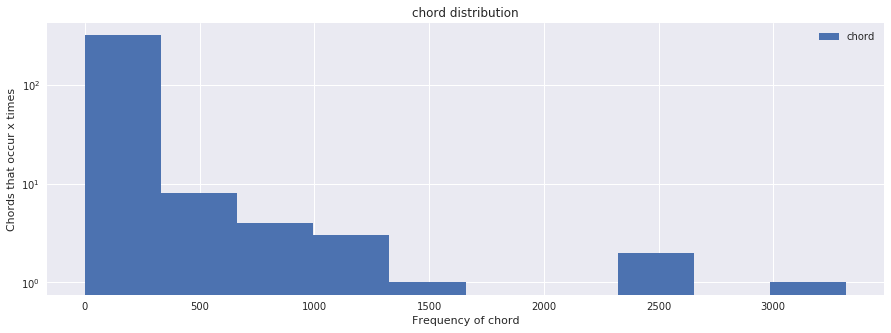

In [3]:
#Count how many times each chord appear
chord_dist = data[['chord']].groupby('chord')['chord'].count()

#Sort them and make them into a dataframe
chord_dist = chord_dist.sort_values(ascending = False)
chord_dist = pd.DataFrame(chord_dist)

#Plot the distribution
ax = chord_dist.plot.hist(figsize = [15,5])
ax.semilogy()
ax.set_xlabel("Frequency of chord")
ax.set_ylabel("Chords that occur x times")
_=ax.set_title("chord distribution")


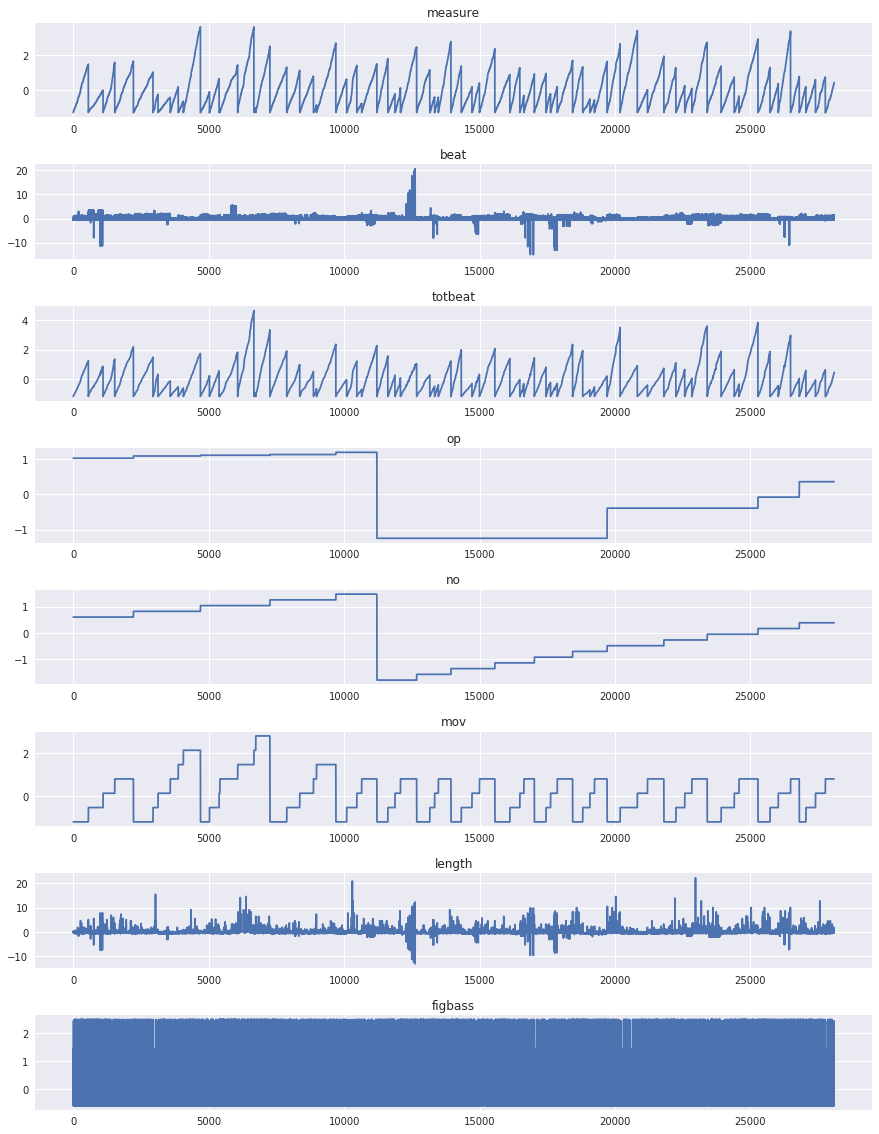

In [4]:
#Let's see if the features have any patterns
to_inspect = ['measure', 'beat', 'totbeat', 'op', 'no', 'mov', 'length',
       'figbass']

#Plot all data for each feature in a subplot
f, axes = plt.subplots(len(to_inspect), 1)
plt.subplots_adjust(hspace = 0.5)
for i,  feature in enumerate(to_inspect):
    tx[feature].plot(ax = axes[i], figsize = [15,20])
    axes[i].set_title(feature)

# Models

In [9]:
def sequential(classes, features, optimizer, loss, metrics):
    """
    A sequential neural network. You train on features until you learn to predict a chord from its corresponding features.
    The kind of model we would have used if we wanted to predict to do chord classification.
    Just for testing purposes.
    """
    #Setup basic model
    model = tf.keras.Sequential()
    
    # Input layer. One node for each feature
    model.add(layers.Dense(32, input_dim = features, activation='relu'))
    
    # Hidden layer
    model.add(layers.Dense(16, activation='relu'))

    # Output layer. One node for each class
    model.add(layers.Dense(classes, activation='softmax'))

    #Compile the model with the chosen parameters
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics= metrics)
    return model

In [4]:
def lstm(lstm_x, lstm_y, optimizer, loss, metrics):
    """
    A LSTM, a neural network operating on sequences to predict next items in a sequence.
    Needs some data preprocessing to generate sequences
    """
    # Input layers
    model = Sequential()
    model.add(LSTM(32, return_sequences=True, input_shape=(lstm_x.shape[1], lstm_x.shape[2]))) 
    
    #Hidden layers
    #model.add(LSTM(32, return_sequences=True))
    model.add(LSTM(32)) 
    
    #Output layers
    model.add(Dense(lstm_y.shape[1], activation='softmax'))

    #Hyperparameters
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)
    return model

In [5]:
def generate_sequences(train_x, train_y, seq_length):
    """
    Input:
        train_x, train_y: the data we want to transform into sequences
        seq_length: the length of the sequences
    Return:
        lstm_x: a matrix where elements are on the form (sequence, sequence length, features)
        lstm_y: a matrix where elements are on the form (sequence, classes)
    Notes: 
        Does not generate sequences for the last (seq_length - 1) datapoints
        Takes quite a lot of computing power - I can only use around 10 % of the data without the notebook shutting down.
        
        
    """
    #containers for the sequences we generate
    lstm_input = []
    lstm_output = []
    
    for i in range(0, train_x.shape[0] - (seq_length +1)):
        #Create a sequence
        in_data = train_x.iloc[i:seq_length + i].values
        lstm_input.append(in_data)
        
        #Select the chord that would have appeared after the sequence
        out_data = train_y.iloc[seq_length + i + 1].values
        lstm_output.append(out_data) 

    #Convert to arrays
    lstm_x = np.array(lstm_input)
    lstm_y = np.array(lstm_output)
    
    return lstm_x, lstm_y


# Generate the sequences for the lstm
lstm_x, lstm_y = generate_sequences(train_x, train_y, 100)

# Train

In [6]:
#Model parameters
classes = y.shape[1]
features = tx.shape[1]
optimizer = tf.train.AdamOptimizer(0.001)
loss = 'categorical_crossentropy'
metrics = ['accuracy']

#Generate model
#model = sequential(classes, features, optimizer, loss, metrics)
model = lstm(lstm_x, lstm_y, optimizer, loss, metrics)


#Train on it and save metrics at each epoch
history = model.fit(lstm_x,
                    lstm_y,
                    epochs = 20,
                    verbose = 1,
                    validation_split = 0.1)

Train on 2437 samples, validate on 271 samples
Epoch 1/20
2437/2437 [==============================] - 22s 9ms/step - loss: 4.7978 - acc: 0.0739 - val_loss: 3.6810 - val_acc: 0.1181
Epoch 2/20
2437/2437 [==============================] - 21s 8ms/step - loss: 3.7342 - acc: 0.1256 - val_loss: 3.6003 - val_acc: 0.1181
Epoch 3/20
2437/2437 [==============================] - 21s 9ms/step - loss: 3.6914 - acc: 0.1256 - val_loss: 3.6106 - val_acc: 0.1181
Epoch 4/20
2437/2437 [==============================] - 21s 9ms/step - loss: 3.6808 - acc: 0.1256 - val_loss: 3.6077 - val_acc: 0.1181
Epoch 5/20
2437/2437 [==============================] - 22s 9ms/step - loss: 3.6769 - acc: 0.1256 - val_loss: 3.6041 - val_acc: 0.1181
Epoch 6/20
2437/2437 [==============================] - 22s 9ms/step - loss: 3.6708 - acc: 0.1256 - val_loss: 3.6127 - val_acc: 0.1181
Epoch 7/20
2437/2437 [==============================] - 22s 9ms/step - loss: 3.6651 - acc: 0.1256 - val_loss: 3.6253 - val_acc: 0.1181
Epoch 8/

# Results

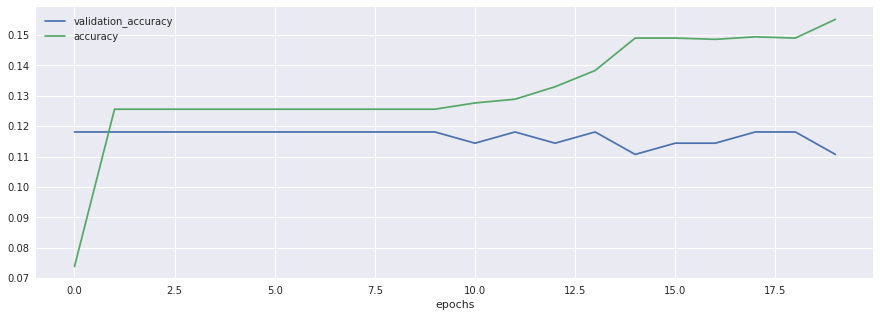

In [10]:
#Save the history of the learning into a dataframe
df = pd.DataFrame({'epochs': history.epoch,
                   'accuracy': history.history['acc'],
                   'validation_accuracy': history.history['val_acc'],
                   'loss': history.history['loss']})


#Plot the the scores on the validation and training sets
df.plot(x='epochs', y = ['validation_accuracy','accuracy'], figsize=[15,5])


In [ ]:
#Get the scores on the test set
scores = model.evaluate(test_x, test_y, verbose=0)
print("Loss on test set = {}\nAccuracy on test set = {}".format(scores[0], scores[1]))